In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
# Constants
NUM_FEATURES = 21
NUM_HIDDEN_NEURON = 25
NUM_CLASSES = 3

learning_rate = 0.01
weight_decays = [0, 1E-3, 1E-6, 1E-9, 1E-12]
epochs = 5000
batch_size = 32
num_folds = 5
seed = 10
np.random.seed(seed)

In [4]:
# Read from CSV
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
trainX, train_Y = train_input[1:, :21], train_input[1:,-1].astype(int)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))

trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
trainY[np.arange(train_Y.shape[0]), train_Y-1] = 1 # one hot matrix

In [5]:
# Shuffle
print('Sample size: %d'%(trainX.shape[0]))
s = np.arange(trainX.shape[0]) # Create an index array
np.random.shuffle(s) # Shuffle the index array
trainX, trainY = trainX[s], trainY[s]

Sample size: 2126


In [6]:
# Split into 70:30 (train:test)
trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.30, random_state=seed, shuffle=True)
print(trainX.shape)

(1488, 21)


In [7]:
# Create the model
def createModel(weight_decay):
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    # Build the graph for the deep net
    w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, NUM_HIDDEN_NEURON], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='w1')
    b1 = tf.Variable(tf.zeros([NUM_HIDDEN_NEURON]), name='b1')
    hidden_relu = tf.nn.relu(tf.matmul(x, w1) + b1, name='relu')

    w2 = tf.Variable(tf.truncated_normal([NUM_HIDDEN_NEURON, NUM_CLASSES], stddev=1.0/math.sqrt(float(NUM_HIDDEN_NEURON))), name='w2')
    b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='b2')
    logits  = tf.matmul(hidden_relu, w2) + b2

    # Apply Softmax activation function to output
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)

    # Loss function with L2 Regularization with b = 10^-6
    loss1 = tf.reduce_mean(cross_entropy)
    regularizers = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
    loss = tf.reduce_mean(loss1 + weight_decay * regularizers)

    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    
    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
    return x, y_, train_op, accuracy

In [8]:
# Main
all_cv_acc = []

# Split dataset into number of folds
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# For each weight decay (0, 1E-3, 1E-6, 1E-9, 1E-12)
for w in weight_decays:
    print('================= For Weight Decay: %g =================' %w)
    decay_acc = []
    
    # Create the model
    x, y_, train_op, accuracy = createModel(w)

    # For each fold (CV)
    for train_index, test_index in kf.split(trainX):
        fTrainX, fTestX = trainX[train_index], trainX[test_index]
        fTrainY, fTestY = trainY[train_index], trainY[test_index]

        # Run experiment
        with tf.Session() as sess:
            print('Experiment %d of %d: ' %(len(decay_acc)+1, num_folds))
            sess.run(tf.global_variables_initializer())

            exp_train_acc = []
            exp_test_acc = []

            # For each epoch
            for e in tqdm(range(epochs)):
                epoch_train_acc = []

                # Run mini-batch
                for start, end in zip(range(0, len(fTrainX), batch_size), range(batch_size, len(fTrainX), batch_size)):
                    train_op.run(feed_dict={x: fTrainX[start:end], y_: fTrainY[start:end]})
                    epoch_train_acc.append(accuracy.eval(feed_dict={x: fTrainX[start:end], y_: fTrainY[start:end]}))

                exp_train_acc.append(np.mean(np.array(epoch_train_acc)))
                exp_test_acc.append(accuracy.eval(feed_dict={x: fTestX, y_: fTestY}))

#                 if e % 100 == 0:
#                     print('Iter: %d' %e, ' | ', 'Train acc: %g' %exp_train_acc[e], ' | ', 'Test acc: %g' %exp_test_acc[e])

        decay_acc.append(exp_test_acc)
        
    # After all experiments are completed, compute mean
    all_cv_acc.append(np.mean(np.array(decay_acc), axis=0))
    print()

================= For Weight Decay: 0 =================
Experiment 1 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:45<00:00, 17.50it/s]


Experiment 2 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:37<00:00, 18.00it/s]


Experiment 3 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:29<00:00, 18.58it/s]


Experiment 4 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:30<00:00, 18.51it/s]


Experiment 5 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:26<00:00, 18.77it/s]



================= For Weight Decay: 0.001 =================
Experiment 1 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:28<00:00, 18.64it/s]


Experiment 2 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:29<00:00, 18.56it/s]


Experiment 3 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:29<00:00, 18.57it/s]


Experiment 4 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:35<00:00, 18.18it/s]


Experiment 5 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:53<00:00, 17.02it/s]



================= For Weight Decay: 1e-06 =================
Experiment 1 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:47<00:00, 17.41it/s]


Experiment 2 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:40<00:00, 17.85it/s]


Experiment 3 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:40<00:00, 17.80it/s]


Experiment 4 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:01<00:00, 16.56it/s]


Experiment 5 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:53<00:00, 17.06it/s]



================= For Weight Decay: 1e-09 =================
Experiment 1 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:49<00:00, 17.25it/s]


Experiment 2 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:51<00:00, 17.17it/s]


Experiment 3 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:50<00:00, 17.20it/s]


Experiment 4 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:50<00:00, 17.23it/s]


Experiment 5 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:49<00:00, 17.26it/s]



================= For Weight Decay: 1e-12 =================
Experiment 1 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:49<00:00, 17.29it/s]


Experiment 2 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:49<00:00, 17.24it/s]


Experiment 3 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:51<00:00, 17.17it/s]


Experiment 4 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:42<00:00, 17.67it/s]


Experiment 5 of 5: 


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:23<00:00, 18.97it/s]


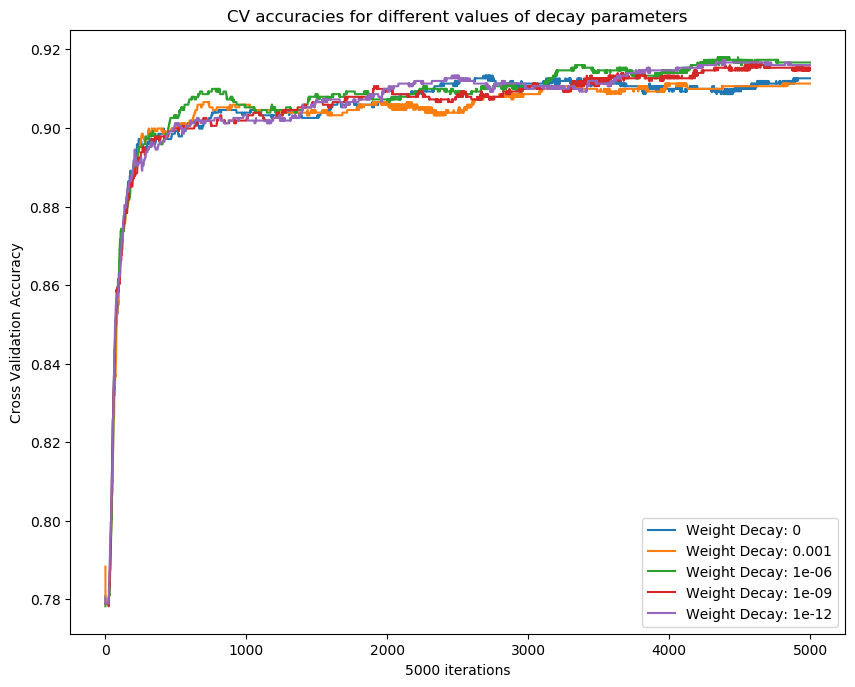

In [10]:
# Plot curves
plt.figure(1, figsize=(10, 8), dpi= 100)
plt.title('CV accuracies for different values of decay parameters')

for w, i in zip(weight_decays, range(len(weight_decays))):
    plt.plot(range(epochs), all_cv_acc[i], label='Weight Decay: %g' %w)

plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Cross Validation Accuracy')
plt.legend()
plt.savefig('PartA_Qn4a_WeightDecay.png')
plt.show()